## Random Forest model for PCOS Dataset (cleaned data)

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTENC
from sklearn.feature_selection import RFE, RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, auc, roc_curve, recall_score, f1_score, precision_score

### Import Dataset

In [33]:
file_path = "./cleaned_data.csv"
data = pd.read_csv(file_path)
data.head()
data.shape
data.columns
data.describe()

,PCOS (Y/N),Age (yrs),BMI,Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Menstrual Cycle Length(days),Marriage Status (Yrs),Pregnant(Y/N),No. of abortions,...,Blood Group_A+,Blood Group_A-,Blood Group_AB+,Blood Group_AB-,Blood Group_B+,Blood Group_B-,Blood Group_O+,Blood Group_O-,Menstrual Cycle(R/I)_irregular,Menstrual Cycle(R/I)_regular
count,529.000000,529.000000,529.00000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,...,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000
mean,0.323251,31.425331,24.32344,73.474480,19.238185,11.152136,4.937618,7.651607,0.387524,0.283554,...,0.200378,0.024575,0.077505,0.003781,0.245747,0.030246,0.381853,0.035917,0.275992,0.724008
std,0.468161,5.430222,4.08396,2.709378,1.697809,0.866512,1.498068,4.801196,0.487646,0.684607,...,0.400662,0.154971,0.267644,0.061429,0.430937,0.171425,0.486301,0.186259,0.447436,0.447436
min,0.000000,20.000000,12.40000,70.000000,16.000000,8.500000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,27.000000,21.60000,72.000000,18.000000,10.500000,5.000000,4.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,31.000000,24.20000,72.000000,18.000000,11.000000,5.000000,7.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,35.000000,26.70000,74.000000,20.000000,11.700000,5.000000,10.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,1.000000,48.000000,38.90000,82.000000,28.000000,14.800000,12.000000,30.000000,1.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Train Test Split and Feature Scaling

In [34]:
X = data.drop(['PCOS (Y/N)'], axis=1)
y = data['PCOS (Y/N)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)

category_col_names = ['Blood Group_A+', 'Blood Group_A-', 'Blood Group_AB+','Blood Group_AB-', 
'Blood Group_B+', 'Blood Group_B-', 'Blood Group_O+', 'Blood Group_O-', 
'Menstrual Cycle(R/I)_irregular', 'Menstrual Cycle(R/I)_regular', 'Weight gain(Y/N)', 
'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)',
'Fast food (Y/N)', 'Reg.Exercise(Y/N)', 'Pregnant(Y/N)']
numeric_col_names = X.loc[:, ~X.columns.isin(category_col_names)].columns

scaler = StandardScaler()
X_train[numeric_col_names] = scaler.fit_transform(X_train[numeric_col_names])
X_test[numeric_col_names] = scaler.transform(X_test[numeric_col_names])

(423, 43)
(106, 43)


### Resampling with SMOTENC

In [35]:
smotenc = SMOTENC(categorical_features=category_col_names, random_state=42)
X_train_resampled, y_train_resampled = smotenc.fit_resample(X_train, y_train)

### Building Random Forest Classifier

In [36]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_resampled, y_train_resampled)
y_pred=rf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_pred, y_test))

Test Accuracy: 0.8962264150943396


### Random Forest Classifier with RFE

In [37]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rfecv = RFECV(estimator=rf, min_features_to_select=1, scoring='roc_auc', cv=5, n_jobs=-1)
X_train_selected = rfecv.fit_transform(X_train_resampled, y_train_resampled)
X_test_selected = rfecv.transform(X_test)
selected_features = X.columns[rfecv.support_]

print("selected features:", selected_features)

rf.fit(X_train_selected, y_train_resampled)
y_pred=rf.predict(X_test_selected)

print("Test Accuracy:", accuracy_score(y_pred, y_test))

selected features: Index(['Age (yrs)', 'BMI', 'Pulse rate(bpm)', 'RR (breaths/min)', 'Hb(g/dl)',
       'Menstrual Cycle Length(days)', 'Marriage Status (Yrs)',
       'No. of abortions', 'I   beta-HCG(mIU/mL)', 'II    beta-HCG(mIU/mL)',
       'FSH/LH', 'Waist:Hip Ratio', 'TSH (mIU/L)', 'AMH(ng/mL)', 'PRL(ng/mL)',
       'Vit D3 (ng/mL)', 'PRG(ng/mL)', 'RBS(mg/dl)', 'Weight gain(Y/N)',
       'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Pimples(Y/N)',
       'Fast food (Y/N)', 'BP _Systolic (mmHg)', 'Follicle No. (L)',
       'Follicle No. (R)', 'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)',
       'Endometrium (mm)', 'Menstrual Cycle(R/I)_irregular',
       'Menstrual Cycle(R/I)_regular'],
      dtype='object')
Test Accuracy: 0.8773584905660378


### Hyperparameter Tuning

In [38]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train_selected, y_train_resampled)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation ROC AUC:", grid_search.best_score_)

rf_best = grid_search.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Cross-Validation ROC AUC: 0.974117310820912


### Model Evaluation

AUC score:  0.957347972972973
New Model Test Accuracy: 0.8867924528301887


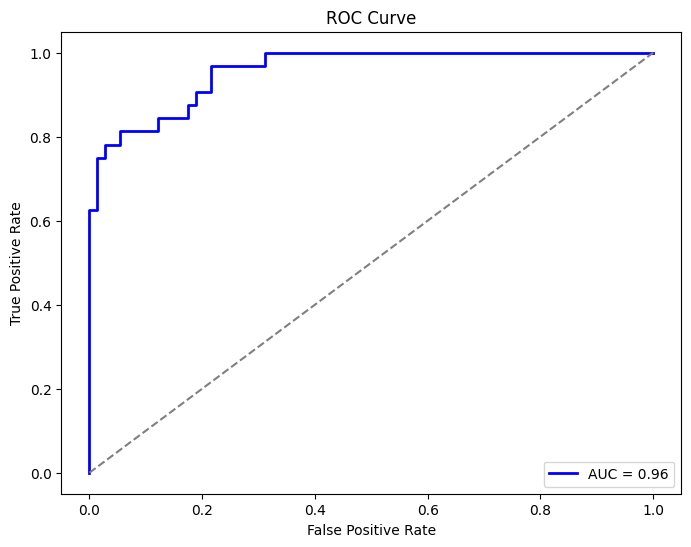

In [39]:
y_pred_best = rf_best.predict(X_test_selected)
y_probs = rf_best.predict_proba(X_test_selected)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

print("AUC score: ", roc_auc)
print("New Model Test Accuracy:", accuracy_score(y_test, y_pred_best))

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], color='gray', linestyle="--")
plt.title("ROC Curve")
plt.legend(loc='lower right')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

### Finding Best Threshold & Model Evaluation

Best threshold: 0.582779761904762
Accuracy:  0.9056603773584906
Precision:  0.8666666666666667
Recall/Sensitivity:  0.8125
F1 Score:  0.8387096774193549
Specificity:  0.9459459459459459


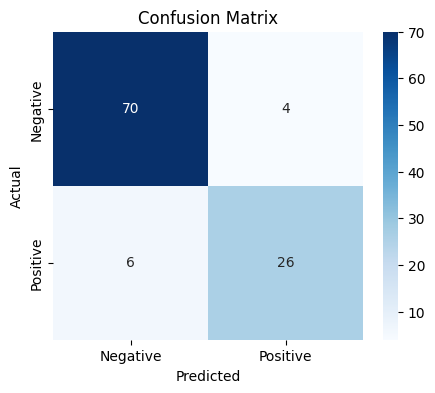

In [40]:
distances = np.sqrt((1 - tpr) ** 2 + fpr ** 2)
best_thresh = thresholds[np.argmin(distances)]
print(f"Best threshold: {best_thresh}")

y_pred_best = [1 if prob >= best_thresh else 0 for prob in y_probs]
print("Accuracy: ", accuracy_score(y_test, y_pred_best))
print("Precision: ", precision_score(y_test, y_pred_best))
print("Recall/Sensitivity: ", recall_score(y_test, y_pred_best))
print("F1 Score: ", f1_score(y_test, y_pred_best))
print("Specificity: ", recall_score(y_test, y_pred_best, pos_label=0))

cm = confusion_matrix(y_test, y_pred_best)
labels = ["True Negatives", "False Positives", "False Negatives", "True Positives"]
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()